Задача 1

In [ ]:
import numpy as np
from scipy.optimize import minimize

X = np.array([-1, 0, 2])
y = np.array([1, -1, -1])

# Линейно ядро
def linear_kernel(x_i, x_j):
    return x_i * x_j

# Лагранжиан за SVM
def lagrangian(alpha):
    sum_alpha = np.sum(alpha)
    sum_kernel = 0
    for i in range(3):
        for j in range(3):
            sum_kernel += alpha[i] * alpha[j] * y[i] * y[j] * linear_kernel(X[i], X[j])
    return - (sum_alpha - 0.5 * sum_kernel)

# Ограничения
constraints = ({
    'type': 'eq',
    'fun': lambda alpha: np.dot(alpha, y)  # Σ α_i * y_i = 0
})

# Гранични условия: α_i ≥ 0
bounds = [(0, None) for _ in range(3)]

initial_alpha = np.zeros(3)

# Оптимизация
result = minimize(lagrangian, initial_alpha, bounds=bounds, constraints=constraints)

# Опорни вектори са тези с α > 0
alphas = result.x
support_vectors = X[alphas > 1e-5]

w = np.sum(alphas * y * X)
support_index = np.where(alphas > 1e-5)[0][0]
b = y[support_index] - w * X[support_index]

print("Стойности на α:", alphas)
print("Опорни вектори:", support_vectors)
print("w:", w)
print("b:", b)
print(f"Уравнението на разделителната линия е: {w} * x + {b} = 0")



Стойности на α: [2.00000000e+00 2.00000000e+00 6.21724894e-15]
Опорни вектори: [-1  0]
w: -1.9999999950393144
b: -0.9999999950393144
Уравнението на разделителната линия е: -1.9999999950393144 * x + -0.9999999950393144 = 0


Задача 2

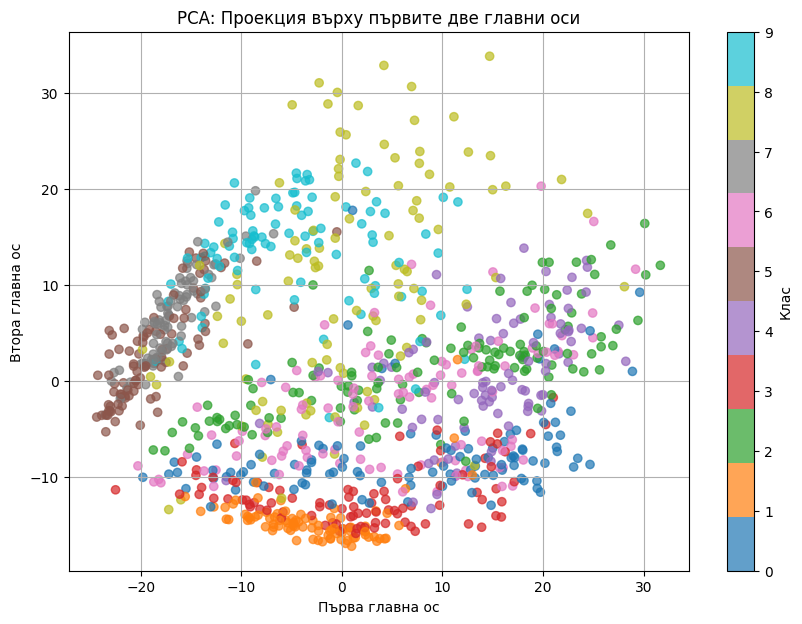

Брой главни оси за 95% дисперсия: 169
Процент дисперсия от първите две главни оси: 37.20%


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

file_path = '/content/data.csv'
df = pd.read_csv(file_path)

#характеристики и целевата променлива
X = df.drop('y', axis=1)
y = df['y']

#Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#Намиране на броя главни оси, които дават не по-малко от 95% от дисперсията
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

#Процент на дисперсията
variance_first_two = np.sum(pca.explained_variance_ratio_[:2]) * 100

#Визуализация на данните върху първите две главни оси
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Клас')
plt.xlabel('Първа главна ос')
plt.ylabel('Втора главна ос')
plt.title('PCA: Проекция върху първите две главни оси')
plt.grid(True)
plt.show()

print(f'Брой главни оси за 95% дисперсия: {n_components_95}')
print(f'Процент дисперсия от първите две главни оси: {variance_first_two:.2f}%')


Задача 3

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

file_path = '/content/data.csv'
data = pd.read_csv(file_path)

X = data.drop(columns=['y'])
y = data['y']

# Разделяне на данните на 90% тренировъчни и 10% тестови
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Намиране на уникалните класове и създаване на комбинации
unique_classes = np.unique(y)
class_combinations = list(combinations(unique_classes, 2))

# Линейно SVM и логистична регресия
svm_results = []
logreg_results = []

for class_pair in class_combinations:
    train_filter = y_train.isin(class_pair)
    test_filter = y_test.isin(class_pair)

    X_train_pair = X_train[train_filter]
    y_train_pair = y_train[train_filter]
    X_test_pair = X_test[test_filter]
    y_test_pair = y_test[test_filter]

    y_train_binary = (y_train_pair == class_pair[1]).astype(int)
    y_test_binary = (y_test_pair == class_pair[1]).astype(int)

    svm_model = SVC(kernel='linear', C=1.0)
    svm_model.fit(X_train_pair, y_train_binary)
    svm_pred = svm_model.predict(X_test_pair)
    svm_accuracy = accuracy_score(y_test_binary, svm_pred)
    svm_results.append((class_pair, svm_accuracy))

    logreg_model = LogisticRegression(max_iter=1000)
    logreg_model.fit(X_train_pair, y_train_binary)
    logreg_pred = logreg_model.predict(X_test_pair)
    logreg_accuracy = accuracy_score(y_test_binary, logreg_pred)
    logreg_results.append((class_pair, logreg_accuracy))

# Сортиране
svm_results_sorted = sorted(svm_results, key=lambda x: x[1], reverse=True)
logreg_results_sorted = sorted(logreg_results, key=lambda x: x[1], reverse=True)

print("\nТоп 5 двойки класове за SVM:")
for pair, acc in svm_results_sorted[:5]:
    print(f"Класове: {pair}, Точност: {acc:.4f}")

print("\nТоп 5 двойки класове за Логистична регресия:")
for pair, acc in logreg_results_sorted[:5]:
    print(f"Класове: {pair}, Точност: {acc:.4f}")

# Мащабиране
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_results_scaled = []
logreg_results_scaled = []

for class_pair in class_combinations:
    train_filter = y_train.isin(class_pair)
    test_filter = y_test.isin(class_pair)

    X_train_pair = X_train_scaled[train_filter]
    y_train_pair = y_train[train_filter]
    X_test_pair = X_test_scaled[test_filter]
    y_test_pair = y_test[test_filter]

    y_train_binary = (y_train_pair == class_pair[1]).astype(int)
    y_test_binary = (y_test_pair == class_pair[1]).astype(int)

    svm_model = SVC(kernel='linear', C=1.0)
    svm_model.fit(X_train_pair, y_train_binary)
    svm_pred = svm_model.predict(X_test_pair)
    svm_accuracy = accuracy_score(y_test_binary, svm_pred)
    svm_results_scaled.append((class_pair, svm_accuracy))

    logreg_model = LogisticRegression(max_iter=1000)
    logreg_model.fit(X_train_pair, y_train_binary)
    logreg_pred = logreg_model.predict(X_test_pair)
    logreg_accuracy = accuracy_score(y_test_binary, logreg_pred)
    logreg_results_scaled.append((class_pair, logreg_accuracy))

svm_results_scaled_sorted = sorted(svm_results_scaled, key=lambda x: x[1], reverse=True)
logreg_results_scaled_sorted = sorted(logreg_results_scaled, key=lambda x: x[1], reverse=True)

print("\nТоп 5 двойки класове за SVM след мащабиране:")
for pair, acc in svm_results_scaled_sorted[:5]:
    print(f"Класове: {pair}, Точност: {acc:.4f}")

print("\nТоп 5 двойки класове за Логистична регресия след мащабиране:")
for pair, acc in logreg_results_scaled_sorted[:5]:
    print(f"Класове: {pair}, Точност: {acc:.4f}")

# Оптимизация на хиперпараметри за SVM с нелинейно ядро
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

class_pair = (0, 2)
train_filter = y_train.isin(class_pair)
test_filter = y_test.isin(class_pair)

X_train_pair = X_train_scaled[train_filter]
y_train_pair = y_train[train_filter]
X_test_pair = X_test_scaled[test_filter]
y_test_pair = y_test[test_filter]

y_train_binary = (y_train_pair == class_pair[1]).astype(int)
y_test_binary = (y_test_pair == class_pair[1]).astype(int)

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pair, y_train_binary)

best_svm_model = grid_search.best_estimator_
best_svm_pred = best_svm_model.predict(X_test_pair)
best_svm_accuracy = accuracy_score(y_test_binary, best_svm_pred)

print(f"\nНай-добри хиперпараметри за SVM с нелинейно ядро: {grid_search.best_params_}")
print(f"Точност на модела с нелинейно ядро: {best_svm_accuracy:.4f}")



Топ 5 двойки класове за SVM:
Класове: (0, 2), Точност: 1.0000
Класове: (0, 5), Точност: 1.0000
Класове: (0, 7), Точност: 1.0000
Класове: (1, 2), Точност: 1.0000
Класове: (1, 4), Точност: 1.0000

Топ 5 двойки класове за Логистична регресия:
Класове: (0, 2), Точност: 1.0000
Класове: (0, 5), Точност: 1.0000
Класове: (0, 7), Точност: 1.0000
Класове: (1, 2), Точност: 1.0000
Класове: (1, 3), Точност: 1.0000

Топ 5 двойки класове за SVM след мащабиране:
Класове: (0, 2), Точност: 1.0000
Класове: (0, 4), Точност: 1.0000
Класове: (0, 5), Точност: 1.0000
Класове: (0, 7), Точност: 1.0000
Класове: (1, 2), Точност: 1.0000

Топ 5 двойки класове за Логистична регресия след мащабиране:
Класове: (0, 2), Точност: 1.0000
Класове: (0, 4), Точност: 1.0000
Класове: (0, 5), Точност: 1.0000
Класове: (0, 7), Точност: 1.0000
Класове: (1, 2), Точност: 1.0000

Най-добри хиперпараметри за SVM с нелинейно ядро: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Точност на модела с нелинейно ядро: 0.9583
